# Zadanie 4: Użycie algorytmu Grovera do problemu znajdowania zbioru dominującego

**Gratulujemy dotrwania do finałowego zadania!**
Ostatnie zadanie jest zadaniem konkursowym, czyli koszt obwodu który stworzycie będzie miał bezpośredni wpływ na waszą pozycję w rankingu. Z tego powodu pomoc organizatorów zostanie ograniczona do minimum, głównie do rozwiązywania prostych problemów związanych z oprogramowaniem Qiskit, Pythonem bądź precyzowania reguł zadań.

Powodzenia w rozwiązaniu poniższego zadania!

# Zbiór dominujący

W poprzednim zadaniu implementowaliśmy algorytm Grovera do znajdowania optymalnego rozwiązania problemu Max-Cut. Innymi słowy, szukaliśmy takiego kolorowania, dla którego liczba krawędzi łączących wierzchołki pokolorowane na dwa różne kolory była możliwie duża.

Szukanie najmniejszego _zbioru dominującego_ (ang. *dominating set*) również polega na szukaniu kolorowania wierzchołków, jednak cel jest inny. Zbiorem dominującym nazywamy taki podzbiór wierzchołków, że każdy wierzchołek grafu jest w tym podzbiorze lub sąsiaduje z którymś z wierzchołków z tego podzbioru. Poniżej zaprezentowaliśmy kilka zbiorów dominujących (wyróżnionych kolorem czerwonym):

<img src="graphics/task4_good_examples.png" width=800/>

Zauważcie, że każdy wierzchołek jest pokolorowany na czerwono lub sąsiaduje z takim wierzchołkiem. Poniżej zaprezentowaliśmy przykłady kolorowania grafów nie dających zbioru dominującego.

<img src="graphics/task4_bad_examples.png" width=400/>

Wierzchołki wyróżnione niebieskim kwadratem nie są w zbiorze oraz nie sąsiadują z wierzchołkiem ze zbioru.

Problem znajdowania zbioru dominującego o najmniejszej liczbie wierzchołków jest trudnym problemem (wręcz NP-trudnym). Jednocześnie problem ten ma dość ważne zastosowanie w praktyce: wyobraźcie sobie, że wierzchołki grafu są powiązane z pewną lokalizacją w mieście i umieszczamy w nich urządzenia mierzące jakieś lokalne parametry (np. niech będą to stacje meteorologiczne). Chcemy, aby bieżące wyniki były przekazywane bezpośrednio do serwera, jednak zamiast wstawiać silny nadajnik przy każdej stacji (co jest kosztowne), możemy wstawić je jedynie przy pewnych wyróżnionych stacjach i przesyłać informacje z pozostałych stacji do sąsiadujących stacji z silnymi nadajnikami. Oczywiście, im mniejsza liczba silnych nadajników tym mniejszy koszt.

## Zadanie konkursowe

W ramach finałowego zadania należy znaleźć możliwe lokalizacje nadajników dla poniższej mapy stacji meteorologicznych. Pamiętaj, że stacja może przesyłać dane najdalej do nadajnika przy stacji, z którą sąsiaduje.

<img src="graphics/task4.png" width=400/>

Skądinąd wiemy, że wystarczy ustawić dokładnie trzy nadajniki, co więcej, minimum trzy nadajniki są potrzebne do rozwiązania problemu.

**Rozwiązanie musi spełniać szereg reguł**:

* Skonstruowany obwód nie może składać się z więcej niż 26 kubitów.
* Należy użyć algorytmu Grovera, który poznaliście w zadaniu drugim, z trzema iteracjami.
* Wynik pomiaru $1$ oznacza, że wierzchołek należy do zbioru dominującego, a wynik $0$, że nie należy.
* Zastosuj jedynie jeden 9-bitowy klasyczny rejestr `c`, w którym są zapisywane wyniki pomiaru. W tym celu możecie korzystać z wzorca poniżej.
* __Uwaga: można skorzystać z informacji, że szukamy położenia trzech nadajników, jednak jest to jedyna informacja dotycząca rozwiązania, z której można skorzystać__. W szczególności nie można implementować wyroczni poprzez wcześniejsze znalezienie rozwiązania klasycznymi metodami. **Pomocnicze pytania:** Czy algorytm który skonstruowałem/am będzie działał dla dowolnego grafu nieskierowanego, jeśli będę znał/a rozmiar zbioru dominującego (powinno być: **tak**)? Czy korzystam z jakichś nietypowych cech grafu (jest nieregularny, niedwudzielny itp.) (powinno być: **nie**)? Czy korzystam z wiedzy jakie jest rozwiązanie (powinno być: **nie**)? 
* Obwód kwantowy może składać się jedynie z dostępnych w Qiskit bramek kwantowych (`x`, `ccx`, `mct`, `z`, `u3`, etc.) oraz pomiarów. Nie można korzystać z operacji nie będących bramkami, typu `reset`, `c_if`, itp, oraz bramki `unitary`. Jeśli masz wątpliwości co do użytej bramki - zapytaj mentorów.
* Nie można korzystać z optymalizatorów do obwodów kwantowych opartych na uczeniu maszynowych bądź heurystycznych innych niż `transpile` użyty poniżej. W `transpile` poniżej nie można zmieniać argumentów.
* **Jako rozwiązanie należy wysłać plik `zadanie_4.json` wygenerowany przez `create_submission` oraz plik `zadanie_4.ipynb` wraz z odpowiednimi komentarzami opisującymi kroki algorytmu.**

<div class="alert alert-block alert-danger">
Symulowanie kwantowych obwodów na klasycznym komputerze jest dość czasochłonnym zadaniem - znajdowanie stanu kwantowego może zająć od kilkunastu sekund, do kilkunastu minut. Dlatego prosimy o cierpliwe czekanie na wynik obliczeń w przypadku wysyłania ich do symulatora IBM, gdyż umieszczenie kilku obliczeń jednocześnie na serwerze (szczególnie przy wielu użytkownikach) może bardzo szybko przeciążyć serwer.
</div>

In [1]:
import numpy as np

from qiskit import *
from qiskit.providers.aer import QasmSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from bnp_challenge_verifier import grade_circuit, verify_solution4, create_submission
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_) 

# Standardowe, niezoptymalizowane rozwiązanie

Graf jest jednoznacznie wyznaczony przez listę zbiorów wierzchołków sąsiadujących z danym wierzchołkiem

In [2]:
# definicja grafu - listy wewnątrz neighbourhoods określają dany wierzchołek (pierwszy element listy) i wierzchołki sąsiadujące
# (następnie elementy listy)
neighbourhoods = [[0,1,6],
                 [1,0,7],
                 [2,3,7],
                 [3,2,8],
                 [4,5,8],
                 [5,4,6],
                 [6,0,7,8,5],
                 [7,1,2,8,6],
                 [8,3,4,6,7]]

In [3]:
qgrover = QuantumRegister(9, name = "main")
cgrover = ClassicalRegister(9, name = "meas")
sum_all = QuantumRegister(4, name = "sum_all")
sum_red_nodes = QuantumRegister(4, name = "sum_red_nodes")
check_node = QuantumRegister(1, name = "c")
phase = QuantumRegister(1, name = "p")

$n$-ty kubit w rejestrze `qgrover` oznacza $n$-ty wierzchołek grafu. Jeśli przynajmniej jeden z kubitów w `neighbourhoods[n]` jest w stanie $|1\rangle$, to znaczy, że do rejestru `sum_red_nodes` trzeba dodać $1$. Jeśli po rozważeniu wszystkich elementów `neighbourhoods` zakodowana w `sum_red_nodes` suma wyniesie $9$, to znaczy, że każdy z wierzchołków grafu jest pomalowany na czerwono lub sąsiaduje z takim wierzchołkiem. W ten sposób można wyznaczyć wszystkie zbiory dominujące grafu.

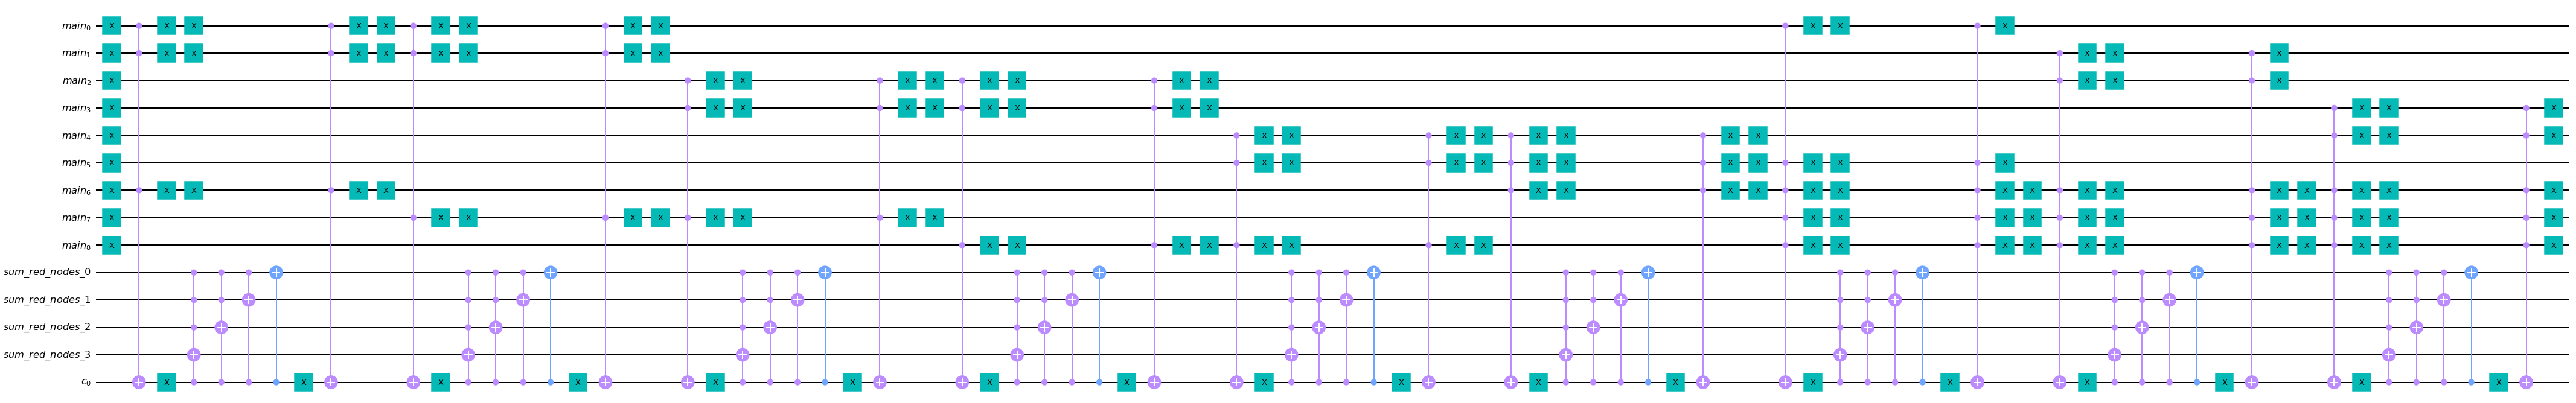

In [4]:
qc_node_check = QuantumCircuit(qgrover, sum_red_nodes, check_node)

for neighbours in neighbourhoods:
    qc_node_check.x([qgrover[v] for v in neighbours])
    qc_node_check.mcx([qgrover[v] for v in neighbours], check_node[0])
    qc_node_check.x([qgrover[v] for v in neighbours])
    
    qc_node_check.x(check_node)
    qc_node_check.mcx([check_node[0], sum_red_nodes[0], sum_red_nodes[1], sum_red_nodes[2]], sum_red_nodes[3])
    qc_node_check.mcx([check_node[0], sum_red_nodes[0], sum_red_nodes[1]], sum_red_nodes[2])
    qc_node_check.ccx(check_node[0], sum_red_nodes[0], sum_red_nodes[1])
    qc_node_check.cx(check_node[0], sum_red_nodes[0])
    qc_node_check.x(check_node)
    
    qc_node_check.x([qgrover[v] for v in neighbours])
    qc_node_check.mcx([qgrover[v] for v in neighbours], check_node[0])
    qc_node_check.x([qgrover[v] for v in neighbours])
    
qc_node_check.draw(output = "mpl", fold = -1)

In [5]:
NodeCheckGate = qc_node_check.to_gate()
NodeCheckGate.name = "NodeCheck"

Aby znaleźć tylko te zbory dominujące, których moc jest równa $3$, należy zsumować liczbę stanów $|1\rangle$ w `qgrover` (wynik zakodować w `sum_all`). Następnie wykonujemy zmianę fazy stanu kwantowego kontrolowaną przez kubity w `sum_all` i `sum_red_nodes` - `sum_all` musi być w stanie $|0011\rangle$, a `sum_red_nodes` w $|1001\rangle$.

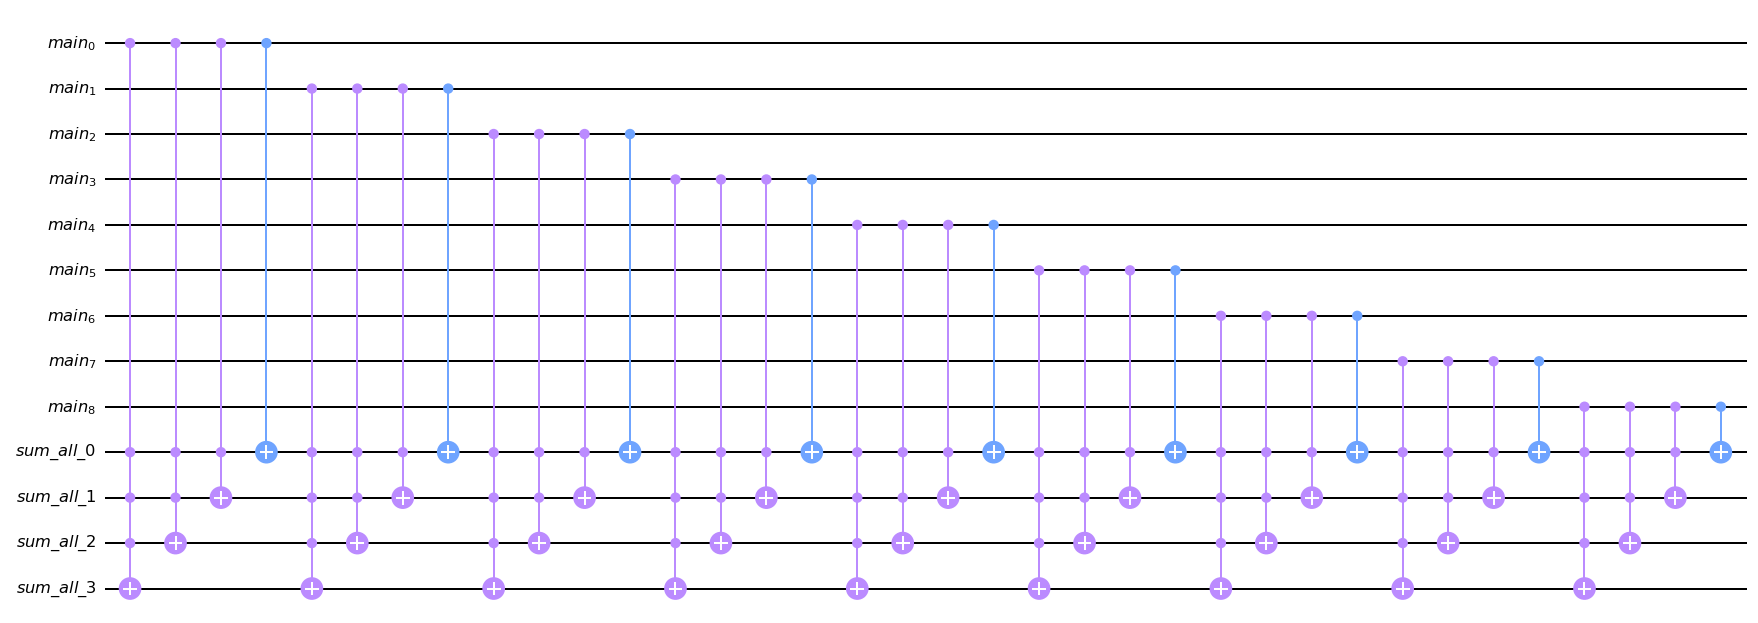

In [6]:
qc_count_ones = QuantumCircuit(qgrover, sum_all)
for idx in range(9):
    qc_count_ones.mcx([qgrover[idx], sum_all[0], sum_all[1], sum_all[2]], sum_all[3])
    qc_count_ones.mcx([qgrover[idx], sum_all[0], sum_all[1]], sum_all[2])
    qc_count_ones.ccx(qgrover[idx], sum_all[0], sum_all[1])
    qc_count_ones.cx(qgrover[idx], sum_all[0])
    
qc_count_ones.draw(output = "mpl", fold = -1)

# komentarz na temat sumatora kwantowego znajduje się poniżej

In [7]:
CountOnesGate = qc_count_ones.to_gate()
CountOnesGate.name = "count_ones"

In [8]:
def inversion_about_average(circuit, register):
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[-1])
    circuit.mcx(register[:-1], register[-1])
    circuit.h(register[-1])
    circuit.x(register)
    circuit.h(register)

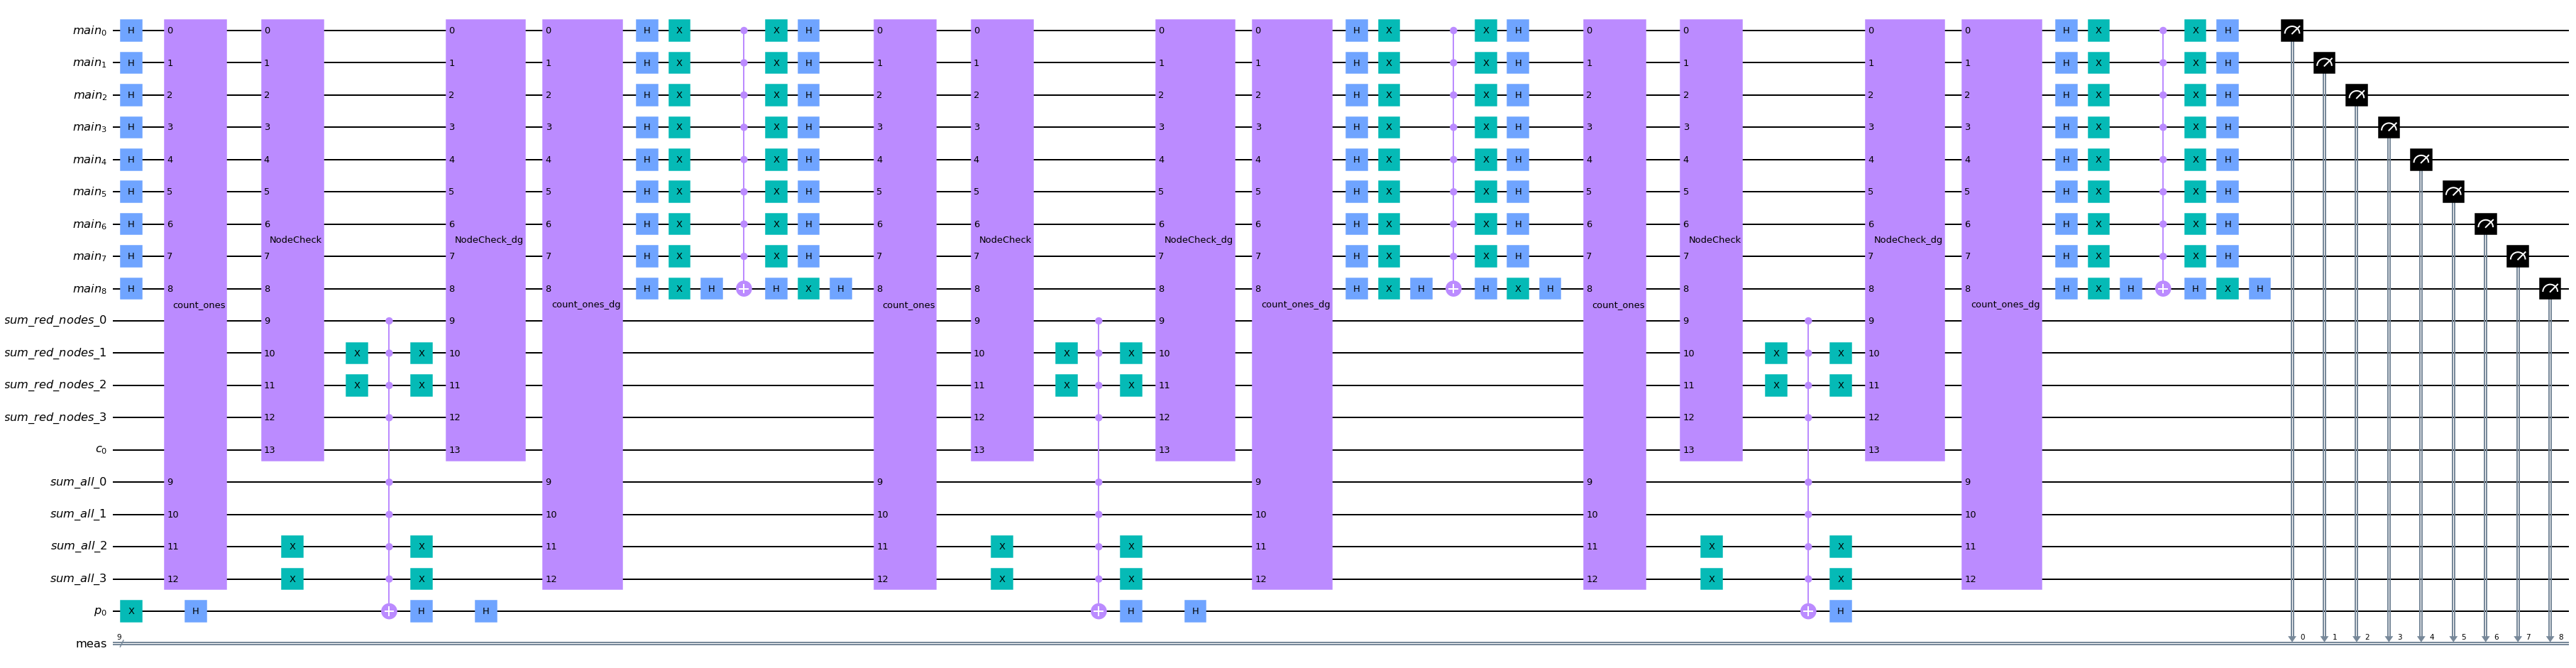

In [9]:
qcirc = QuantumCircuit(qgrover, sum_red_nodes, check_node, sum_all, phase, cgrover)
qcirc.x(phase)
qcirc.h(qgrover)

for iteration in range(3):
    qcirc.append(CountOnesGate, list(qgrover) + list(sum_all))
    qcirc.append(NodeCheckGate, list(qgrover) + list(sum_red_nodes) + list(check_node))
    
    qcirc.h(phase)
    qcirc.x([sum_red_nodes[1], sum_red_nodes[2], sum_all[2], sum_all[3]])
    qcirc.mcx(list(sum_red_nodes) + list(sum_all), phase)
    qcirc.x([sum_red_nodes[1], sum_red_nodes[2], sum_all[2], sum_all[3]])
    qcirc.h(phase)
    
    qcirc.append(NodeCheckGate.inverse(), list(qgrover) + list(sum_red_nodes) + list(check_node))
    qcirc.append(CountOnesGate.inverse(), list(qgrover) + list(sum_all))
    
    inversion_about_average(qcirc, qgrover)
    
qcirc.measure(qgrover, cgrover)
qcirc.draw(output = "mpl", fold = -1)

In [10]:
# weryfikacja rozwiązania
cost = grade_circuit(qcirc)

qcirc = transpile(qcirc, basis_gates=['u3', 'cx']) 
qcirc = pm.run(qcirc)
qasm = QasmSimulator(seed_simulator=46) # nie zmieniaj wartości seed_simulator!
result = qasm.run(qcirc).result().get_counts(qcirc)
# print(result)
verify_solution4(result)

Koszt twojego obwodu wynosi 165423.
Gratulacje, twój obwód wygenerował poprawne wyniki pomiaru! Upewnij się, że twój obwód spełnia pozostałe wymogi zadania.


# Optymalizacja obwodów kwantowych

## Wielokrotnie kontrolowane bramki NOT

In [11]:
control_reg = QuantumRegister(4, name = "q")
target_reg = QuantumRegister(1, name = "t")
ancillia = QuantumRegister(2, name = "a")

Koszt twojego obwodu wynosi 401.


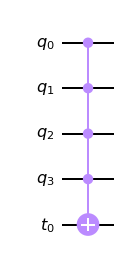

In [12]:
gate0 = QuantumCircuit(control_reg, target_reg)
gate0.mcx(control_reg, target_reg[0])
grade_circuit(gate0)
gate0.draw(output = "mpl")

Koszt twojego obwodu wynosi 340.


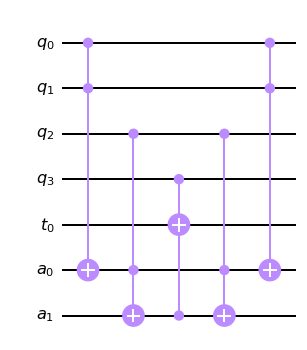

In [13]:
gate1 = QuantumCircuit(control_reg, target_reg, ancillia)
gate1.ccx(control_reg[0], control_reg[1], ancillia[0])
gate1.ccx(ancillia[0], control_reg[2], ancillia[1])
gate1.ccx(ancillia[1], control_reg[3], target_reg[0])
gate1.ccx(ancillia[0], control_reg[2], ancillia[1])
gate1.ccx(control_reg[0], control_reg[1], ancillia[0])
grade_circuit(gate1)
gate1.draw(output = "mpl")

Okazuje się, że bramkę Toffoliego możemy znacznie uprościć jeśli fazy amplitud danych stanów kwantowych nie są istotne. 

Koszt twojego obwodu wynosi 68.


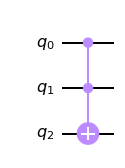

In [14]:
qc0 = QuantumCircuit(3)
qc0.ccx(0,1,2)
grade_circuit(qc0)
qc0.draw(output = "mpl")

Koszt twojego obwodu wynosi 34.


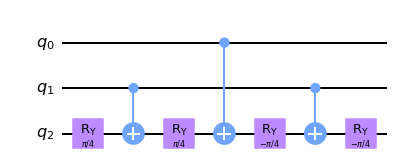

In [15]:
qc1 = QuantumCircuit(3)
qc1.ry(np.pi/4, 2)
qc1.cx(1, 2)
qc1.ry(np.pi/4, 2)
qc1.cx(0, 2)
qc1.ry(-np.pi/4, 2)
qc1.cx(1, 2)
qc1.ry(-np.pi/4, 2)
grade_circuit(qc1)
qc1.draw(output = "mpl")

In [16]:
def simplified_toffoli(circuit, control_qubit0, control_qubit1, target_qubit):
    circuit.ry(np.pi/4, target_qubit)
    circuit.cx(control_qubit1, target_qubit)
    circuit.ry(np.pi/4, target_qubit)
    circuit.cx(control_qubit0, target_qubit)
    circuit.ry(-np.pi/4, target_qubit)
    circuit.cx(control_qubit1, target_qubit)
    circuit.ry(-np.pi/4, target_qubit)

Powyższy obwód różni się od bramki Toffoliego jedynie tym, że zmienia fazę stanu $|101\rangle$ o $\pi$. Jeśli jednak wiemy, że $q_2$ jest początkowo w stanie $|0\rangle$ (np. jak przy rozpisywaniu bramek wielokrotnie kontrolowanych z pomocą dodatkowych kubitów), to ten układ będzie działał dokładnie w taki sam sposób jak CCNOT.

In [17]:
# koszt czterokrotnie kontrolowanej bramki NOT
gate2 = QuantumCircuit(control_reg, target_reg, ancillia)
simplified_toffoli(gate2, control_reg[0], control_reg[1], ancillia[0])
simplified_toffoli(gate2, ancillia[0], control_reg[2], ancillia[1])
gate2.ccx(ancillia[1], control_reg[3], target_reg[0]) # nie zawsze chcemy zmieniać fazy target_reg
simplified_toffoli(gate2, ancillia[0], control_reg[2], ancillia[1])
simplified_toffoli(gate2, control_reg[0], control_reg[1], ancillia[0])
x = grade_circuit(gate2)

Koszt twojego obwodu wynosi 204.


Zmniejszyliśmy koszt $\text{C}^4\text{NOT}$ prawie dwukrotnie!

Więcej przydatnych własności bramek kwantowych można znaleść w artykule: [Ref.1](https://arxiv.org/abs/quant-ph/9503016v1)

# Kwantowy sumator

Chcemy skonstruować algorytm kwantowy dodający bit wejściowy $x_{\text{IN}}$ do dowolnej liczby $y=\sum_{k=0}^N y_k 2^k, y_k\in\{0,1\}$ (zakodowanej kubitowo - qubit encoding). Załóżmy, że $y<6$. Najprostszy sposób:

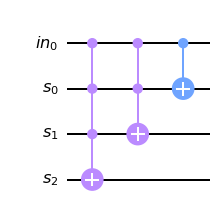

In [18]:
input_reg = QuantumRegister(1, name = "in")
sum_reg = QuantumRegister(3, name = "s")
qc0 = QuantumCircuit(input_reg, sum_reg)
qc0.mcx([input_reg[0], sum_reg[0], sum_reg[1]], sum_reg[2])
qc0.ccx(input_reg[0], sum_reg[0], sum_reg[1])
qc0.cx(input_reg[0], sum_reg[0])

qc0.draw(output = "mpl")

Wprowadzając kubity pomocnicze i korzystając z powyższego uproszczenia bramek CNOT otrzymujemy:

In [19]:
def adder4(circuit, qr_input, qr_sum, ancillia):
    simplified_toffoli(circuit, qr_input, qr_sum[0], ancillia[0])
    simplified_toffoli(circuit, ancillia[0], qr_sum[1], ancillia[1])
    simplified_toffoli(circuit, ancillia[1], qr_sum[2], qr_sum[3])
    circuit.cx(ancillia[1], qr_sum[2])
    simplified_toffoli(circuit, ancillia[0], qr_sum[1], ancillia[1])
    circuit.cx(ancillia[0], qr_sum[1])
    simplified_toffoli(circuit, qr_input, qr_sum[0], ancillia[0])
    circuit.cx(qr_input, qr_sum[0])

Jeśli wiemy, że suma będzie mniejsza niż 8 lub 4, to sumator można uprościć odpowiednio do:

In [20]:
def adder3(circuit, qr_input, qr_sum, ancillia):
    simplified_toffoli(circuit, qr_input, qr_sum[0], ancillia[0])
    simplified_toffoli(circuit, ancillia[0], qr_sum[1], qr_sum[2])
    circuit.cx(ancillia[0], qr_sum[1])
    simplified_toffoli(circuit, qr_input, qr_sum[0], ancillia[0])
    circuit.cx(qr_input, qr_sum[0])

In [21]:
def adder2(circuit, qr_input, qr_sum):
    simplified_toffoli(circuit, qr_input, qr_sum[0], qr_sum[1])
    circuit.cx(qr_input, qr_sum[0])

## Zoptymalizowany obwód

In [22]:
qgrover = QuantumRegister(9, name = "main")
cgrover = ClassicalRegister(9, name = "meas")
sum_all = QuantumRegister(4, name = "sum_all")
sum_red_nodes = QuantumRegister(4, name = "sum_red_nodes")
check_node = QuantumRegister(1, name = "c")
ancillia = QuantumRegister(8, name = "a")

In [23]:
def inversion_about_average(circuit, qr_grover, ancillia):
    circuit.h(qr_grover)
    circuit.x(qr_grover)
    circuit.h(qr_grover[8])
    simplified_toffoli(circuit, qr_grover[0], qr_grover[1], ancillia[0])
    simplified_toffoli(circuit, ancillia[0], qr_grover[2], ancillia[1])
    simplified_toffoli(circuit, ancillia[1], qr_grover[3], ancillia[2])
    simplified_toffoli(circuit, ancillia[2], qr_grover[4], ancillia[3])
    simplified_toffoli(circuit, ancillia[3], qr_grover[5], ancillia[4])
    simplified_toffoli(circuit, ancillia[4], qr_grover[6], ancillia[5])
    circuit.ccx(ancillia[5], qr_grover[7], qr_grover[8])
    simplified_toffoli(circuit, ancillia[4], qr_grover[6], ancillia[5])
    simplified_toffoli(circuit, ancillia[3], qr_grover[5], ancillia[4])
    simplified_toffoli(circuit, ancillia[2], qr_grover[4], ancillia[3])    
    simplified_toffoli(circuit, ancillia[1], qr_grover[3], ancillia[2])
    simplified_toffoli(circuit, ancillia[0], qr_grover[2], ancillia[1])
    simplified_toffoli(circuit, qr_grover[0], qr_grover[1], ancillia[0])
    circuit.h(qr_grover[8])
    circuit.x(qr_grover)
    circuit.h(qr_grover)

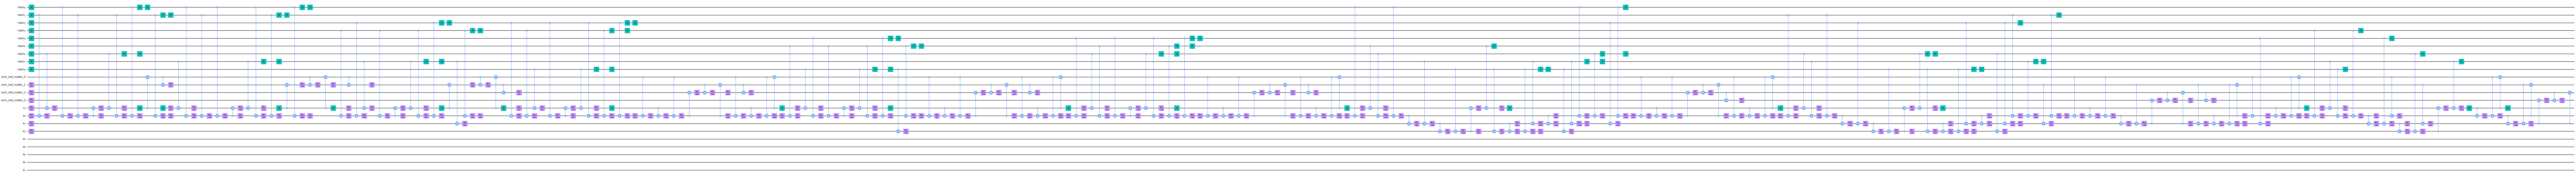

In [24]:
qc_node_check = QuantumCircuit(qgrover, sum_red_nodes, check_node, ancillia)

iteration = 0
for neighbours in neighbourhoods:
    
    # nie trzeba resetować rejestru "check_node" oraz kubitów pomocniczych przy dodawaniu dla iteration == 8,
    # ponieważ po zastosowaniu bramki odwrotnej, po zmianie kontrolowanej zmianie znaku rejestru "phase"
    # zastosujemy bramkę odwrotną do "NodeCheckGate", która przywróci stan początkowy "check_node", "sum_red_nodes" oraz "ancillia[0,1,2]"
    # (jeśli przy "CountOnesGate" będziemy używali innych kubitów pomocniczych)
    
    if len(neighbours) == 3:
        qc_node_check.x([qgrover[v] for v in neighbours])
        simplified_toffoli(qc_node_check, qgrover[neighbours[0]], qgrover[neighbours[1]], ancillia[0])
        simplified_toffoli(qc_node_check, ancillia[0], qgrover[neighbours[2]], check_node[0])
        if iteration != 8: simplified_toffoli(qc_node_check, qgrover[neighbours[0]], qgrover[neighbours[1]], ancillia[0])
        qc_node_check.x([qgrover[v] for v in neighbours])
        
    elif len(neighbours) == 5:
        qc_node_check.x([qgrover[v] for v in neighbours])
        simplified_toffoli(qc_node_check, qgrover[neighbours[0]], qgrover[neighbours[1]], ancillia[0])
        simplified_toffoli(qc_node_check, ancillia[0], qgrover[neighbours[2]], ancillia[1])
        simplified_toffoli(qc_node_check, ancillia[1], qgrover[neighbours[3]], ancillia[2])
        simplified_toffoli(qc_node_check, ancillia[2], qgrover[neighbours[4]], check_node[0])
        if iteration != 8:
            simplified_toffoli(qc_node_check, ancillia[1], qgrover[neighbours[3]], ancillia[2])
            simplified_toffoli(qc_node_check, ancillia[0], qgrover[neighbours[2]], ancillia[1])
            simplified_toffoli(qc_node_check, qgrover[neighbours[0]], qgrover[neighbours[1]], ancillia[0])
        qc_node_check.x([qgrover[v] for v in neighbours])
        
    # oczywiście dla innego dowolnego grafu, znając "neighbourhoods" można dodać kolejne "elif-y". 
    # można też posłużyć się pętlą for idx in range(len(neighbours)-const.): ... aby dodawać kolejne 
    # simplified_toffoli(qc_node_check, ancillia[idx], qgrover[neighbours[idx + 2]], ancillia[idx + 1])
    # jednak powyższy zapis wydaje mi się najbardziej przejrzysty, a jego uogólnienie jest dość łatwe
    
    qc_node_check.x(check_node)
    if iteration == 0:
        qc_node_check.cx(check_node[0], sum_red_nodes[0])
        
    elif iteration < 3:
        simplified_toffoli(qc_node_check, check_node[0], sum_red_nodes[0], sum_red_nodes[1])
        qc_node_check.cx(check_node[0], sum_red_nodes[0])
        
    elif iteration < 7:
        simplified_toffoli(qc_node_check, check_node[0], sum_red_nodes[0], ancillia[0])
        simplified_toffoli(qc_node_check, ancillia[0], sum_red_nodes[1], sum_red_nodes[2])
        qc_node_check.cx(ancillia[0], sum_red_nodes[1])
        simplified_toffoli(qc_node_check, check_node[0], sum_red_nodes[0], ancillia[0])
        qc_node_check.cx(check_node[0], sum_red_nodes[0])
        
    else:
        simplified_toffoli(qc_node_check, check_node[0], sum_red_nodes[0], ancillia[0])
        simplified_toffoli(qc_node_check, ancillia[0], sum_red_nodes[1], ancillia[1])
        simplified_toffoli(qc_node_check, ancillia[1], sum_red_nodes[2], sum_red_nodes[3])
        qc_node_check.cx(ancillia[1], sum_red_nodes[2])
        if iteration < 8: simplified_toffoli(qc_node_check, ancillia[0], sum_red_nodes[1], ancillia[1])
        qc_node_check.cx(ancillia[0], sum_red_nodes[1])
        if iteration < 8: simplified_toffoli(qc_node_check, check_node[0], sum_red_nodes[0], ancillia[0])
        qc_node_check.cx(check_node[0], sum_red_nodes[0])
        
    qc_node_check.x(check_node)
    iteration += 1
    
qc_node_check.draw(output = "mpl", fold = -1)

In [25]:
NodeCheckGate = qc_node_check.to_gate()
NodeCheckGate.name = "NodeCheck"

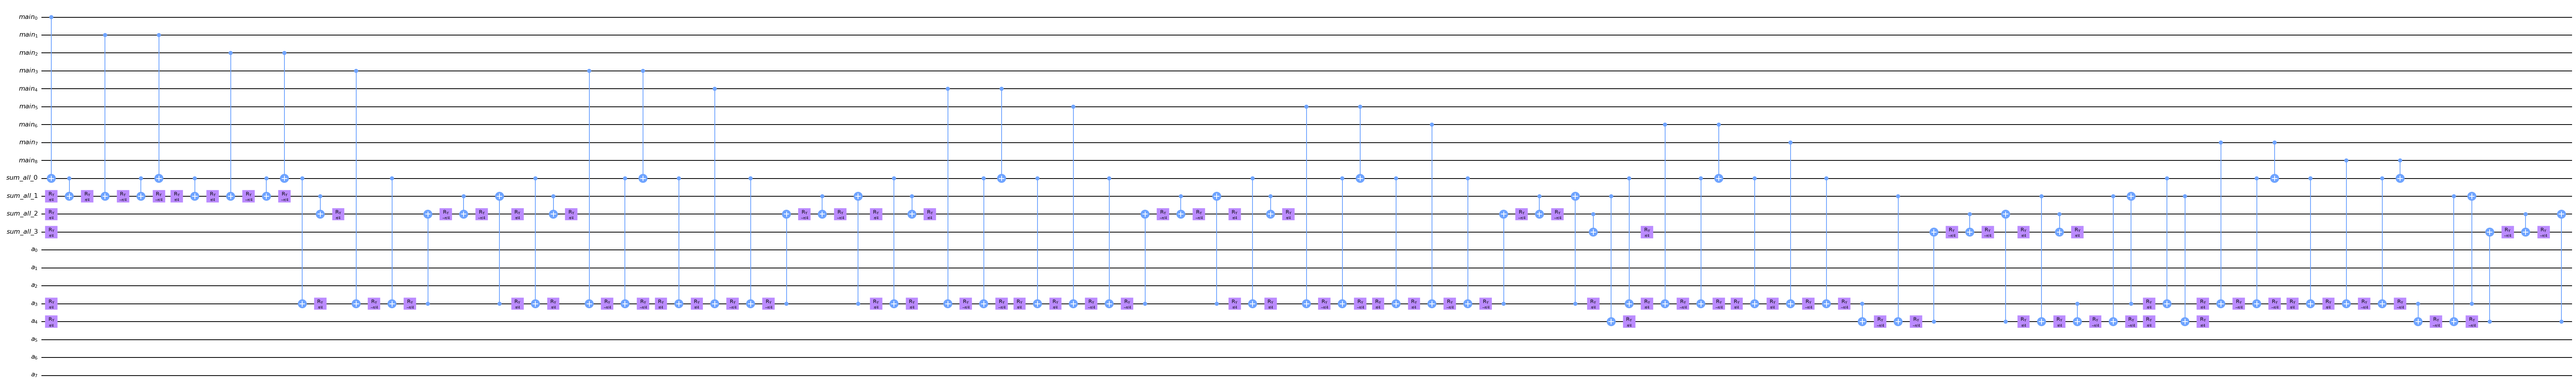

In [26]:
qc_count_ones = QuantumCircuit(qgrover, sum_all, ancillia)
for idx in range(9):
    
    if idx == 0:
        # adder1
        qc_count_ones.cx(qgrover[idx], sum_all[0])  # dodając 0 lub 1 do 0 nie można otrzymać >1
        
    elif idx < 3:
        # adder2
        simplified_toffoli(qc_count_ones, qgrover[idx], sum_all[0], sum_all[1])
        qc_count_ones.cx(qgrover[idx], sum_all[0])
        
    elif idx < 7:
        # adder3
        simplified_toffoli(qc_count_ones, qgrover[idx], sum_all[0], ancillia[3])
        simplified_toffoli(qc_count_ones, ancillia[3], sum_all[1], sum_all[2])
        qc_count_ones.cx(ancillia[3], sum_all[1])
        simplified_toffoli(qc_count_ones, qgrover[idx], sum_all[0], ancillia[3])
        qc_count_ones.cx(qgrover[idx], sum_all[0])
        
    else:
        # adder4
        simplified_toffoli(qc_count_ones, qgrover[idx], sum_all[0], ancillia[3])
        simplified_toffoli(qc_count_ones, ancillia[3], sum_all[1], ancillia[4])
        simplified_toffoli(qc_count_ones, ancillia[4], sum_all[2], sum_all[3])
        qc_count_ones.cx(ancillia[4], sum_all[2])
        if idx < 8: simplified_toffoli(qc_count_ones, ancillia[3], sum_all[1], ancillia[4])
        qc_count_ones.cx(ancillia[3], sum_all[1])
        if idx < 8: simplified_toffoli(qc_count_ones, qgrover[idx], sum_all[0], ancillia[3])
        qc_count_ones.cx(qgrover[idx], sum_all[0])
        
# wyrażenia "if idx < 8:" pełnią taką samą funkcję co w "NodeCheckGate"
    
qc_count_ones.draw(output = "mpl", fold = -1)

In [27]:
CountOnesGate = qc_count_ones.to_gate()
CountOnesGate.name = "count_ones"

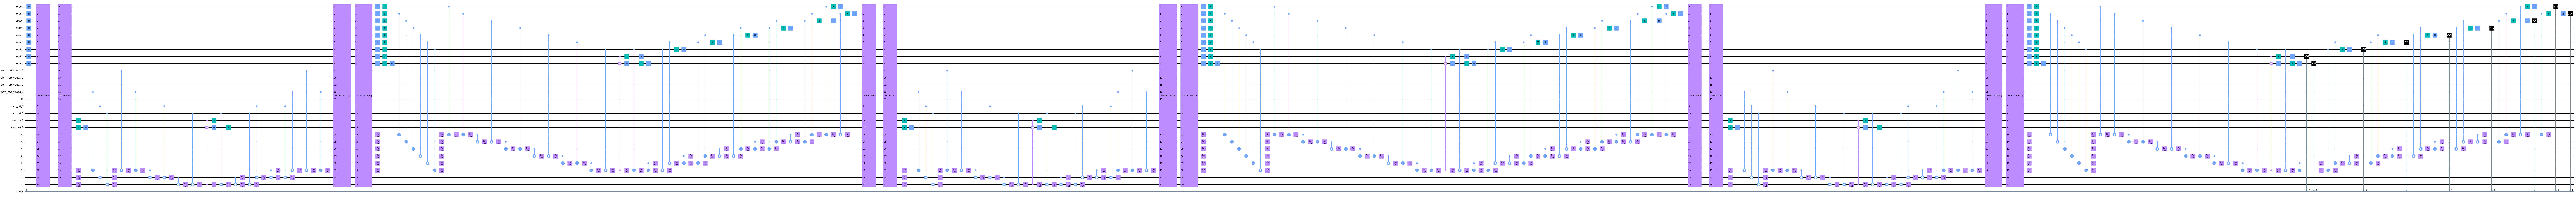

In [28]:
qcirc = QuantumCircuit(qgrover, sum_red_nodes, check_node, sum_all, ancillia, cgrover)
qcirc.h(qgrover)

for iteration in range(3):
    qcirc.append(CountOnesGate, list(qgrover) + list(sum_all) + list(ancillia))
    qcirc.append(NodeCheckGate, list(qgrover) + list(sum_red_nodes) + list(check_node) + list(ancillia))
    
    # Jeśli graf ma 9 wierzchołków, to największa liczba zakodowana przez "sum_red_nodes" to 1001. Jeśli więc "sum_red_nodes[0]" i 
    # "sum_red_nodes[3]" będą w stanie |1>, to na pewno stan całego rejestru "sum_red_nodes" to |1001>. Wystarczy zatem bramka NOT
    # kontrolowana przez "sum_red_nodes[0]" i "sum_red_nodes[3]". W przypadku innej liczby wierzchołków również można odpowiednio wybrać
    # kontrolujące kubity. Na przykład jeśli liczba wierzchołków jest równa 18, to największa zakodowana przez "sum_red_nodes"  liczba to
    # 10010 (oczywiście w tym przypadku rejestr "sum_red_nodes" ma 5 kubitów). Dlatego wystarczy NOT kontrolowana przez "sum_red_nodes[4]"
    # i "sum_red_nodes[1]".
    
    # Wszystkie kubity z rejestru "sum_all" muszą kontrolować daną bramkę NOT.
    
    # Zauważmy, że nie trzeba dodawać specjalnego rejestru, na którym wykonujemy warunkowo operację zmiany fazy o pi. 
    # Kontrolowaną operację HXH można wykonać na kubicie z rejestru "sum_all" lub "sum_red_nodes" który ma być w stanie |1>
    qcirc.x([sum_all[2], sum_all[3]])
    qcirc.h(sum_all[3])
    
    simplified_toffoli(qcirc, sum_red_nodes[0], sum_red_nodes[3], ancillia[5])
    simplified_toffoli(qcirc, ancillia[5], sum_all[0], ancillia[6])
    simplified_toffoli(qcirc, ancillia[6], sum_all[1], ancillia[7])
    qcirc.ccx(ancillia[7], sum_all[2], sum_all[3])
    #simplified_toffoli(qcirc, ancillia[7], sum_all[2], sum_all[3])
    simplified_toffoli(qcirc, ancillia[6], sum_all[1], ancillia[7])
    simplified_toffoli(qcirc, ancillia[5], sum_all[0], ancillia[6])
    simplified_toffoli(qcirc, sum_red_nodes[0], sum_red_nodes[3], ancillia[5])
    
    qcirc.h(sum_all[3])
    qcirc.x([sum_all[2], sum_all[3]])
    
    qcirc.append(NodeCheckGate.inverse(), list(qgrover) + list(sum_red_nodes) + list(check_node) + list(ancillia))
    qcirc.append(CountOnesGate.inverse(), list(qgrover) + list(sum_all) + list(ancillia))
    
    inversion_about_average(qcirc, qgrover, ancillia)
    
qcirc.measure(qgrover, cgrover)
qcirc.draw(output = "mpl", fold = -1)

In [29]:
# weryfikacja rozwiązania
cost = grade_circuit(qcirc)

qcirc = transpile(qcirc, basis_gates=['u3', 'cx']) 
qcirc = pm.run(qcirc)
qasm = QasmSimulator(seed_simulator=46) # nie zmieniaj wartości seed_simulator!
result = qasm.run(qcirc).result().get_counts(qcirc)
# print(result)
verify_solution4(result)

Koszt twojego obwodu wynosi 20517.
Gratulacje, twój obwód wygenerował poprawne wyniki pomiaru! Upewnij się, że twój obwód spełnia pozostałe wymogi zadania.


Jeśli Twoje rozwiązanie zostało zaakceptowane przez nasz weryfikator, stwórz i prześlij plik zgłoszeniowy **razem z tym notebookiem uzupełnionym o Twoje rozwiązanie wraz z komentarzami** (łącznie dwa pliki). Z Twoich komentarzy powinno być jasne jak działa Twoje rozwiązanie. Upewnij się, że w `twoje_id` poniżej podałeś/aś swój poprawny identyfikator!

Zgłoszeń można dokonać [tutaj](https://ibm.ent.box.com/f/4c9101c0616f4897920a02a67d077321).

In [30]:
twoje_id = "a9f9d9d01b"
create_submission(qcirc, result, twoje_id)

Wygenerowaliśmy plik do wysłania o nazwie: zgloszenie_konkursowe.json. Nie zapomnij wysłać notebooka z rozwiązaniem!
